In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import LucaM185 
device = torch.device("cuda:0")
#device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")


In [3]:
with open("datasets/enwik8", "r") as f:
    load = f.read()[:1000000]
print(load[:200])

<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.3/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/


In [4]:
class MyInputs:
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.data) - self.sequence_length
        
    def __getitem__(self, idx):
        start_indices = idx.unsqueeze(1) + torch.arange(self.sequence_length)
        return self.data[start_indices]


In [5]:
# Restricting to ASCII characters
texttoint = {chr(i): i for i in range(256)}
inttotext = {i: chr(i) for i in range(256)}
dataset = torch.tensor([texttoint[c] for c in load if c in texttoint])

vocab_size = len(texttoint)
sequence_length = 20
val_set = int(len(dataset)*0.1)

inputs = MyInputs(dataset[val_set:-1-sequence_length], sequence_length)
labels = MyInputs(dataset[val_set+1:-sequence_length], sequence_length)
val_inputs = MyInputs(dataset[:val_set], sequence_length)
val_labels = MyInputs(dataset[1:val_set+1], sequence_length)

print(len(dataset))

997275


# Re-Running self attention 

In [14]:
class FullyConnected(nn.Module):  
    def __init__(self, in_size, out_size, hidden_size, n_layers):
        super(FullyConnected, self).__init__()

        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        for fc in self.fcx:
            x = F.gelu(fc(x))
        x = self.fc2(x)
        return x
    
class Attention(nn.Module):
    def __init__(self, emb_size: int):
        super().__init__()
        self.emb_size = emb_size
        self.queries = nn.Linear(emb_size, emb_size)
        self.keys    = nn.Linear(emb_size, emb_size)
        self.values  = nn.Linear(emb_size, emb_size)

    def forward(self, x):
        B, L, _ = x.shape

        q = self.queries(x)
        k = self.keys(x)
        v = self.values(x)

        scores = (q @ k.transpose(-2, -1)) / (x.shape[-1] ** 0.5)
        causal_mask = torch.tril(torch.ones(L, L, device=x.device)).bool()
        scores = scores.masked_fill(~causal_mask, float('-inf'))
        attn = F.softmax(scores, dim=-1)

        out = (attn @ v)
        return out
    
class Block(nn.Module): 
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()

        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att = Attention(emb_size)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc = FullyConnected(emb_size, emb_size, hidden_size, n_layers)

    def forward(self, x):
        x = x + (self.att(self.prenorm1(x)))
        x = x + (self.fc(self.prenorm2(x)))
    
        return x

class Transformer(nn.Module): 
    def __init__(self, vocab_size, emb_size, n_blocks, head_size, hidden_size, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb = nn.Embedding(sequence_length, emb_size)
        1
        self.blocks = nn.ModuleList([Block(emb_size, hidden_size, n_layers) for _ in range(n_blocks)])
        self.LinOut = nn.Linear(emb_size, vocab_size)

    def forward(self, x):
        x = (self.embedding(x) + self.posemb(torch.arange(x.size(1)).to(x.device))) 

        for block in self.blocks:
            x = block(x)
            
        x = self.LinOut(x)
        return x


Millions of parameters: 1.98
Epoch ___0 - Loss: 5.859 - Val Loss: 5.607


Epoch _200 - Loss: 2.284 - Val Loss: 2.250
Epoch _400 - Loss: 2.045 - Val Loss: 2.041
Epoch _600 - Loss: 1.873 - Val Loss: 1.890
Epoch _800 - Loss: 1.778 - Val Loss: 1.826
Epoch 1000 - Loss: 1.723 - Val Loss: 1.735
Epoch 1200 - Loss: 1.659 - Val Loss: 1.796
Epoch 1400 - Loss: 1.619 - Val Loss: 1.826
Epoch 1600 - Loss: 1.577 - Val Loss: 1.690
Epoch 1800 - Loss: 1.510 - Val Loss: 1.653


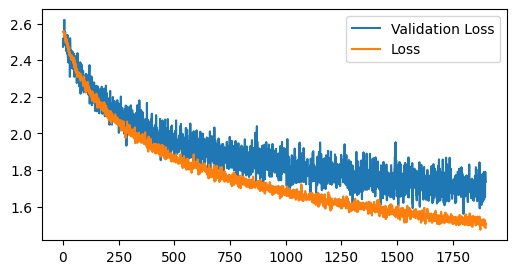

In [15]:
model = Transformer(vocab_size=vocab_size, emb_size=256, n_blocks=4, head_size=256, hidden_size=256, n_layers=2).to(device)
torch.compile(model)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 2000
batch_size = 1024
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.03) 

lossi = []
vlossi = []

for epoch in range(epochs):
    model.train()
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred.view(-1, vocab_size), labels[indexes].to(device).view(-1))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    with torch.no_grad():
        model.eval()
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))
        loss = F.cross_entropy(pred.view(-1, vocab_size), val_labels[indexes].to(device).view(-1))
        vlossi.append(loss.item())

    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {lossi[-1]:.3f} - Val Loss: {vlossi[-1]:.3f}")

plt.figure(figsize=(6, 3))  
plt.plot(vlossi[100:], label='Validation Loss')
plt.plot(lossi[100:], label='Loss')
plt.legend()

# Multiple Heads (MHA)

In [ ]:
class FullyConnected(nn.Module):  
    def __init__(self, in_size, out_size, hidden_size, n_layers):
        super(FullyConnected, self).__init__()

        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        for fc in self.fcx:
            x = F.gelu(fc(x))
        x = self.fc2(x)
        return x
    
class Attention(nn.Module):
    def __init__(self, emb_size: int, heads: int = 4):
        super().__init__()
        assert emb_size % heads == 0, "emb_size must be divisible by heads"
        self.emb_size = emb_size
        self.heads = heads
        self.head_dim = emb_size // heads

        self.queries = nn.Linear(emb_size, emb_size)
        self.keys    = nn.Linear(emb_size, emb_size)
        self.values  = nn.Linear(emb_size, emb_size)

    def forward(self, x):
        B, L, _ = x.shape                    # (batch, seq_len, emb)
        H, D = self.heads, self.head_dim     # heads, dim per head

        # project and split into heads: (B, H, L, D)
        q = self.queries(x).view(B, L, H, D).transpose(1, 2)
        k = self.keys(x)   .view(B, L, H, D).transpose(1, 2)
        v = self.values(x) .view(B, L, H, D).transpose(1, 2)

        # scaled dot-product attention
        scores = (q @ k.transpose(-2, -1)) / (D ** 0.5)        # (B, H, L, L)
        causal_mask = torch.tril(torch.ones(L, L, device=x.device)).bool()
        scores = scores.masked_fill(~causal_mask, float('-inf'))  # ~ is the not operator (in place of "== 0")
        attn = F.softmax(scores, dim=-1)

        # (B, H, L, D) → (B, L, H, D) → (B, L, E)
        out = (attn @ v).transpose(1, 2).reshape(B, L, self.emb_size)
        return out
    
class Block(nn.Module): 
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()

        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att = Attention(emb_size)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc = FullyConnected(emb_size, emb_size, hidden_size, n_layers)

    def forward(self, x):
        x = x + (self.att(self.prenorm1(x)))
        x = x + (self.fc(self.prenorm2(x)))
    
        return x

class Transformer(nn.Module): 
    def __init__(self, vocab_size, emb_size, n_blocks, head_size, hidden_size, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb = nn.Embedding(sequence_length, emb_size)
        self.blocks = nn.ModuleList([Block(emb_size, hidden_size, n_layers) for _ in range(n_blocks)])
        self.LinOut = nn.Linear(emb_size, vocab_size)

    def forward(self, x):
        x = (self.embedding(x) + self.posemb(torch.arange(x.size(1)).to(x.device))) 

        for block in self.blocks:
            x = block(x)
            
        x = self.LinOut(x)
        return x


Millions of parameters: 1.98
Epoch ___0 - Loss: 5.785 - Val Loss: 5.514
Epoch _200 - Loss: 2.262 - Val Loss: 2.308
Epoch _400 - Loss: 1.981 - Val Loss: 2.041
Epoch _600 - Loss: 1.836 - Val Loss: 1.901
Epoch _800 - Loss: 1.764 - Val Loss: 1.772
Epoch 1000 - Loss: 1.665 - Val Loss: 1.770
Epoch 1200 - Loss: 1.603 - Val Loss: 1.795
Epoch 1400 - Loss: 1.544 - Val Loss: 1.688
Epoch 1600 - Loss: 1.517 - Val Loss: 1.718
Epoch 1800 - Loss: 1.503 - Val Loss: 1.540


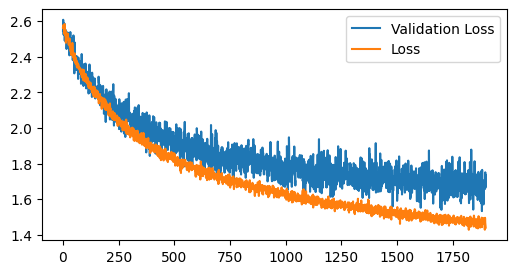

In [ ]:
model = Transformer(vocab_size=vocab_size, emb_size=256, n_blocks=4, head_size=256, hidden_size=256, n_layers=2).to(device)
torch.compile(model)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 2000
batch_size = 1024
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.03) 

lossi = []
vlossi = []

for epoch in range(epochs):
    model.train()
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred.view(-1, vocab_size), labels[indexes].to(device).view(-1))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    with torch.no_grad():
        model.eval()
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))
        loss = F.cross_entropy(pred.view(-1, vocab_size), val_labels[indexes].to(device).view(-1))
        vlossi.append(loss.item())

    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {lossi[-1]:.3f} - Val Loss: {vlossi[-1]:.3f}")

plt.figure(figsize=(6, 3))  
plt.plot(vlossi[100:], label='Validation Loss')
plt.plot(lossi[100:], label='Loss')
plt.legend()

In [ ]:
# demo of inference speed

text = val_inputs[:0]
model.eval()

for i in range(100):
    next_token = model(text).argmax(dim=-1)
    text = torch.cat([text, next_token], dim=1)

print(text)

# Multiple cached heads (MLA)

In [19]:
import math

class FullyConnected(nn.Module):  
    def __init__(self, in_size, out_size, hidden_size, n_layers):
        super(FullyConnected, self).__init__()

        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        for fc in self.fcx:
            x = F.gelu(fc(x))
        x = self.fc2(x)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, cache_len):
        super().__init__()
        assert emb_size % num_heads == 0, "emb_size must be divisible by num_heads"
        self.emb_size  = emb_size
        self.num_heads = num_heads
        self.head_dim  = emb_size // num_heads
        self.scale     = math.sqrt(self.head_dim)
        self.cache_len = cache_len

        self.q_proj = nn.Linear(emb_size, emb_size)
        self.k_proj = nn.Linear(emb_size, emb_size)
        self.v_proj = nn.Linear(emb_size, emb_size)

        self.register_buffer("cache_k", torch.zeros(1, num_heads, cache_len, self.head_dim))
        self.register_buffer("cache_v", torch.zeros(1, num_heads, cache_len, self.head_dim))
        self.step = 0

    def _split_heads(self, x):
        B, T, C = x.shape
        return x.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

    def _merge_heads(self, x):
        B, H, T, D = x.shape
        return x.transpose(1, 2).contiguous().view(B, T, H * D)

    def forward(self, x, autoregressive=False):
        if autoregressive:
            logits, v = self._update_qkv(x)
        else:
            logits, v = self._compute_qkv(x)
        att = torch.softmax(logits / self.scale, dim=-1)
        out = torch.matmul(att, v)
        return self._merge_heads(out)

    def _compute_qkv(self, x, build_cache=False):
        q = self._split_heads(self.q_proj(x))
        k = self._split_heads(self.k_proj(x))
        v = self._split_heads(self.v_proj(x))

        if build_cache:
            L = x.size(1)
            if L > self.cache_len:
                raise ValueError("sequence length exceeds cache_len")
            self.cache_k[:, :, :L, :] = k
            self.cache_v[:, :, :L, :] = v
            self.step = L

        T = x.size(1)
        mask = torch.tril(torch.ones(T, T, device=x.device, dtype=torch.bool))
        logits = torch.einsum("bhqd,bhkd->bhqk", q, k)
        logits = logits.masked_fill(~mask, float("-inf"))
        return logits, v

    def _update_qkv(self, x):
        assert x.size(0) == 1, "batch size 1 only"
        if self.step == 0:
            return self._compute_qkv(x, build_cache=True)

        q = self._split_heads(self.q_proj(x[:, -1:, :]))
        k = self._split_heads(self.k_proj(x[:, -1:, :]))
        v = self._split_heads(self.v_proj(x[:, -1:, :]))

        if self.step >= self.cache_len:
            raise RuntimeError("KV cache overflow")
        self.cache_k[:, :, self.step:self.step+1, :] = k
        self.cache_v[:, :, self.step:self.step+1, :] = v
        self.step += 1

        logits = torch.einsum("bhqd,bhkd->bhqk", q, self.cache_k[:, :, :self.step, :])
        return logits, self.cache_v[:, :, :self.step, :]

class Block(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers, num_heads, cache_len):
        super().__init__()
        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att      = MultiHeadAttention(emb_size, num_heads, cache_len)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc       = FullyConnected(emb_size, emb_size, hidden_size, n_layers)

    def forward(self, x, **kwargs):
        x = x + self.att(self.prenorm1(x), **kwargs)
        x = x + self.fc(self.prenorm2(x))
        return x

class Transformer(nn.Module):
    def __init__(self, vocab_size, emb_size, n_blocks,
                 head_size, hidden_size, n_layers, cache_len):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb    = nn.Embedding(sequence_length, emb_size)
        self.blocks    = nn.ModuleList([Block(emb_size, hidden_size, n_layers, emb_size//head_size, cache_len) for _ in range(n_blocks)])
        self.out = nn.Linear(emb_size, vocab_size)

    def forward(self, x, **kwargs):
        x = self.embedding(x) + self.posemb(torch.arange(x.size(1), device=x.device))

        if kwargs.get("autoregressive", False) and self.blocks[-1].att.step != 0: 
            x = x[:, -1:] # We select the last token after positional encodings 
        for block in self.blocks:
            x = block(x, **kwargs)
        return self.out(x)
    
    def reset_cache(self):
        for block in self.blocks:
            block.att.step = 0
    

Millions of parameters: 1.98
Epoch ___0 - Loss: 5.947 - Val Loss: 5.737
Epoch _200 - Loss: 2.269 - Val Loss: 2.279
Epoch _400 - Loss: 1.970 - Val Loss: 2.127
Epoch _600 - Loss: 1.827 - Val Loss: 1.903
Epoch _800 - Loss: 1.696 - Val Loss: 1.974
Epoch 1000 - Loss: 1.638 - Val Loss: 1.796
Epoch 1200 - Loss: 1.600 - Val Loss: 1.771
Epoch 1400 - Loss: 1.593 - Val Loss: 1.652
Epoch 1600 - Loss: 1.493 - Val Loss: 1.686
Epoch 1800 - Loss: 1.485 - Val Loss: 1.639


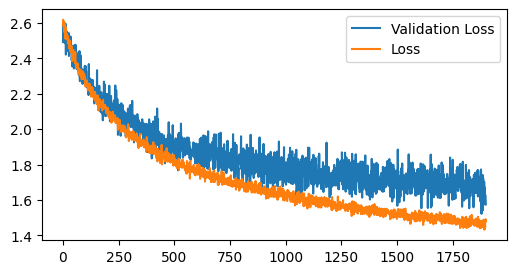

In [20]:
model = Transformer(vocab_size=len(inttotext), emb_size=256, n_blocks=4, head_size=64, hidden_size=256, n_layers=2, cache_len=2048).to(device)
torch.compile(model)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 2000
batch_size = 1024
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.03) 

lossi = []
vlossi = []

for epoch in range(epochs):
    model.train()
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred.view(-1, vocab_size), labels[indexes].to(device).view(-1))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    with torch.no_grad():
        model.eval()
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))
        loss = F.cross_entropy(pred.view(-1, vocab_size), val_labels[indexes].to(device).view(-1))
        vlossi.append(loss.item())

    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {lossi[-1]:.3f} - Val Loss: {vlossi[-1]:.3f}")

plt.figure(figsize=(6, 3))  
plt.plot(vlossi[100:], label='Validation Loss')
plt.plot(lossi[100:], label='Loss')
plt.legend()

In [32]:
import math

class FullyConnected(nn.Module):  
    def __init__(self, in_size, out_size, hidden_size, n_layers):
        super(FullyConnected, self).__init__()

        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        for fc in self.fcx:
            x = F.gelu(fc(x))
        x = self.fc2(x)
        return x

class Attention(nn.Module):
    """Fixed-size (2048) KV cache.  Refill at training-time, append at eval-time."""
    def __init__(self, emb_size: int, n_heads=4, cache_len=2048):
        super().__init__()
        self.emb_size  = emb_size
        self.cache_len = cache_len
        self.n_heads   = n_heads

        self.keys    = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values  = nn.Linear(emb_size, emb_size)

        self.register_buffer("cache_k",  torch.zeros(1, cache_len, emb_size))
        self.register_buffer("cache_v",  torch.zeros(1, cache_len, emb_size))
        self.step = 0 

    def forward(self, x, autoregressive=False):
        if autoregressive:   
            qk, v = self.update_qkv(x)
        else:
            qk, v = self.compute_qkv(x)

        att = torch.softmax(qk / math.sqrt(self.emb_size), dim=-1)
        return torch.matmul(att, v)

    def compute_qkv(self, x, build_cache=False):
        q, k, v = self.queries(x), self.keys(x), self.values(x)

        if build_cache:
            L = x.shape[1]
            self.cache_k[:, :L, :]   = k
            self.cache_v[:, :L, :]   = v
            self.step = L
    
        q = q.view(x.shape[0], -1, self.n_heads, self.emb_size//self.n_heads).transpose(1, 2)
        k = k.view(x.shape[0], -1, self.n_heads, self.emb_size//self.n_heads).transpose(1, 2)
        v = v.view(x.shape[0], -1, self.n_heads, self.emb_size//self.n_heads).transpose(1, 2)

        qk = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.emb_size)
        tril = torch.tril(torch.ones(x.shape[1], x.shape[1], device=x.device, dtype=torch.bool))
        qk = qk.masked_fill(tril == 0, float("-inf"))
        qk = qk.reshape(x.shape[0], -1, self.n_heads*self.emb_size)
        v = v.reshape(x.shape[0], -1, self.n_heads*self.emb_size)
        return qk, v

    def update_qkv(self, x):
        assert x.shape[0] == 1, "Only batch size 1 is supported"
        if self.step == 0: return self.compute_qkv(x, build_cache=True)
        
        q = self.queries (x[:, -1, :]).unsqueeze(1).view(x.shape[0], -1, self.n_heads, self.emb_size//self.n_heads).transpose(1, 2)
        k = self.keys    (x[:, -1, :]).unsqueeze(1).view(x.shape[0], -1, self.n_heads, self.emb_size//self.n_heads).transpose(1, 2)
        v = self.values  (x[:, -1, :]).unsqueeze(1).view(x.shape[0], -1, self.n_heads, self.emb_size//self.n_heads).transpose(1, 2)

        self.cache_k[:, :, self.step:self.step+1, :] = k
        self.cache_v[:, :, self.step:self.step+1, :] = v

        self.step += 1
        qk = torch.matmul(q, self.cache_k[:, :self.step, :].transpose(-2, -1))
        v = v.reshape(x.shape[0], -1, self.n_heads*self.emb_size)

        return qk, self.cache_v[:, :self.step, :]

class Block(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers, cache_len):
        super().__init__()
        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att      = Attention(emb_size, 4, cache_len)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc       = FullyConnected(emb_size, emb_size, hidden_size, n_layers)

    def forward(self, x, **kwargs):
        x = x + self.att(self.prenorm1(x), **kwargs)
        x = x + self.fc(self.prenorm2(x))
        return x

class Transformer(nn.Module):
    def __init__(self, vocab_size, emb_size, n_blocks,
                 head_size, hidden_size, n_layers, cache_len):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb    = nn.Embedding(sequence_length, emb_size)
        self.blocks    = nn.ModuleList([Block(emb_size, hidden_size, n_layers, cache_len) for _ in range(n_blocks)])
        self.out = nn.Linear(emb_size, vocab_size)

    def forward(self, x, **kwargs):
        x = self.embedding(x) + self.posemb(torch.arange(x.size(1), device=x.device))

        if kwargs.get("autoregressive", False) and self.blocks[-1].att.step != 0: 
            x = x[:, -1:] # We select the last token after positional encodings 
        for block in self.blocks:
            x = block(x, **kwargs)
        return self.out(x)
    
    def reset_cache(self):
        for block in self.blocks:
            block.att.step = 0
    



In [33]:
model = Transformer(vocab_size=len(inttotext), emb_size=256, n_blocks=4, head_size=64, hidden_size=256, n_layers=2, cache_len=2048).to(device)
torch.compile(model)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 2000
batch_size = 1
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.03) 

lossi = []
vlossi = []

for epoch in range(epochs):
    model.train()
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred.view(-1, vocab_size), labels[indexes].to(device).view(-1))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    with torch.no_grad():
        model.eval()
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))
        loss = F.cross_entropy(pred.view(-1, vocab_size), val_labels[indexes].to(device).view(-1))
        vlossi.append(loss.item())

    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {lossi[-1]:.3f} - Val Loss: {vlossi[-1]:.3f}")

plt.figure(figsize=(6, 3))  
plt.plot(vlossi[100:], label='Validation Loss')
plt.plot(lossi[100:], label='Loss')
plt.legend()

Millions of parameters: 1.98


RuntimeError: shape '[1, -1, 1024]' is invalid for input of size 1600